# Навигация и краткое описание

**Разделы:**
- XGBoost
- LightGBM
- CatBoost

# Подготовка к работе с моделями

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import sys
sys.path.append('..')
from utils import load_processed_data, ModelsRegressionHistory

# Заранее установим несколько констант
RANDOM_STATE = 42

# Загрузка данных
X_train, X_test, y_train, y_test = load_processed_data()
history_models = ModelsRegressionHistory()

# Теория

Бустинг - последовательно обучает модели, где каждая следующая модель исправляет ошибки предыдущих, фокусируясь на плохо предсказанных примерах. Итоговое предсказание формируется путем взвешенного объединения всех моделей.

**более подробную теорию вы можете просмотреть в 2 блокноте*

# Создание моделей

## XGBoost

Считается самой популярной модификацией градиентного бустинга на сегодняшний день. Большая часть соревнований с использованием классического машинного обучения выигрывается с использованием этой модели.

XGBoost - это "золотой стандарт" машинного обучения с табличными данными \[[источник](https://www.geeksforgeeks.org/machine-learning/xgboost-for-regression/)\]. 
Давайте разберём по какой причине XGBoost так хороша:
1) Регуляризация
    В функцию потерь добавлена регуляризация, которая предотвращает переобучение.
    $ Obj(0) = MSE(0) +  Lasso(0)$
    * MSE(0) - функция потерь
    * Lasso(0) - регуляризатор
2) Разбиение
    Построение дерева требует поиска лучшего разбиения по каждому признаку. XGBoost вместо того, чтоб брать весь датасет из 10.000 обьектов (цифра приведена к примеру) возьмёт 100 случайных объектов и выполнит разбиение по ним - это сэкономит огромное количество времени, при минимальной потере качества
3) Разряженные данные
    В датасетах полно пропущенных значений, а также нулей. XGBoost умеет обрабатывать такие данные. Модель автоматически сделает "виток" в дереве для таких данных.
4) Системная оптимизация
    * Модель может разбивать данные параллельно на всех доступных ядрах системы.
    * Часто используемые ланные кэшируются

![XGBoost дерево](../data/images/trees/xgboost.png)

*Мы не будем на данный момент выжимать все соки из каждой последующей модели. И если сейчас получится приемлимый результат, знайте что это не лучший показатель этой модели.*

In [2]:
# хорошим тоном при разработке моделей является вынесение параметров в отдельный словарь, 
# что мы сейчас и сделаем

params = {
    'objective': 'reg:squarederror', 
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

In [3]:
xgbr = XGBRegressor(
    **params
)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [4]:
history_models.add_model(xgbr, "tree_model", xgbr.get_params(), "XGBR", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.952,0.02,0.0006,0.0248


А так же мы можем просматреть влияние фичь на предсказания. Какие свойства обьекта большего всего влияют на предсказание.

In [5]:
importance = xgbr.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    data={
            'features': list(importance.keys()),
            'score': list(importance.values())
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,duration,110.0
1,days_left,103.0
2,flight_value,89.0
3,class_Economy,49.0
4,stops_encoded,46.0


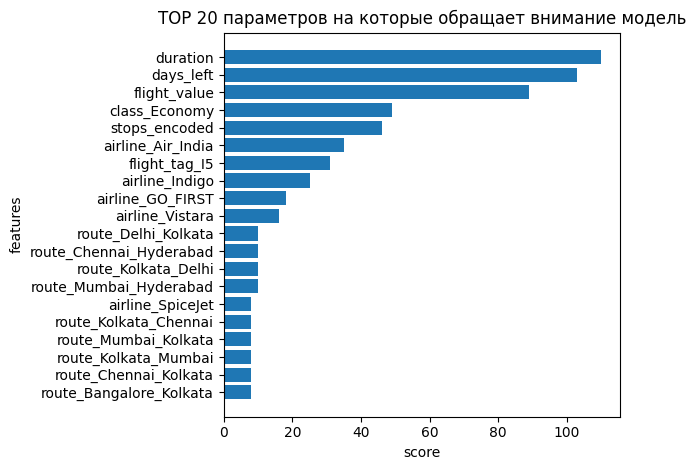

In [6]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.title('TOP 20 параметров на которые обращает внимание модель')
plt.ylabel('features')
plt.xlabel('score')
plt.tight_layout()
plt.show()

Теперь в заключении скажем про преимущества и недостатки `XGBoost`

Преимущества:
* высокая скорость обучения и точность прогноза;
* возможность работы с пропусками;
* гибкость в конфигурации.

Недостатки:
* сложно подобрать гиперпараметры(нужен комплексный подход для использования cross-validation);

## LightGBM

Теперь разберём LightGBM(Light Gradient Boosting Machine) - реализация градиентного бустинга от компании "микро мягких"(Microsoft), способная обрабатывать большие наборы данных и при этом обеспечивать точность \[[источник](https://machinelearningmastery.com/exploring-lightgbm-leaf-wise-growth-with-gbdt-and-goss/)\].

Разберём 3 основных момента этой модели.

1) GOSS(Gradient-Based One-Side Sampling)
    Суть этого метода заключается в сортировке и выборе лучших образцов с наибольшим градиентом - это означает, что именно этим данным следует уделить особое внимание, поскольку на них дерево будет ошибкать больше.
2) Leaf-wise Tree Growth
    Метод при котором модель строятся в глубину. Рост продолжается в листовом узле с наибольшим информативным приростом. Такой подход часто превосходит симметричные деревья.

![стратегия](../data/images/trees/leaf_wise_tree_growth_strategy.png)

3) EFB(Exclusive Feature Bundling) 
    Обьединяет разные категориальные фичи в одну фичу, если они крайне редко встречаются вместе.


Схема представленная ниже наглядно описывает логику работы LGBM

![схема LGBM](../data/images/trees/algorithm_lgbm.png)

In [8]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

In [10]:
lgbm = LGBMRegressor(
    **params
)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 240018, number of used features: 79
[LightGBM] [Info] Start training from score 9.331057


In [11]:
history_models.add_model(lgbm, "tree_model", lgbm.get_params(), "LGBM", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.9520,0.0200,0.0006,0.0248
1,LGBMRegressor,tree_model,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM,0.1419,0.0400,0.2000,0.9676,0.0157,0.0004,0.0202


In [17]:
importance_df = pd.DataFrame(
    data={
            'features': lgbm.feature_name_,
            'score': lgbm.feature_importances_
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,flight_value,590
1,duration,431
2,days_left,284
3,stops_encoded,110
4,airline_Indigo,87


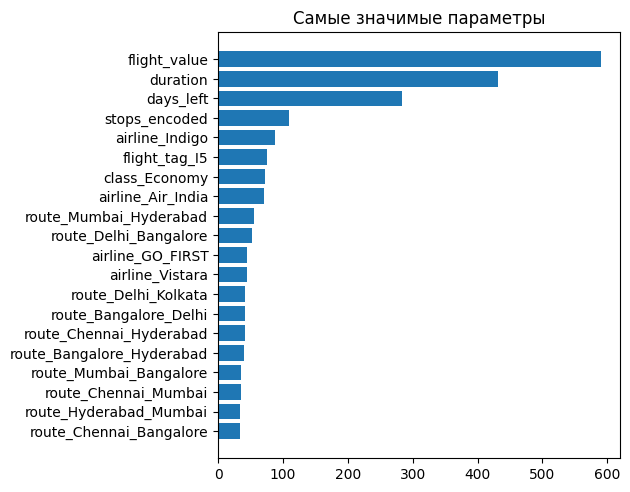

In [20]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.tight_layout()
plt.title('Самые значимые параметры')
plt.show()

Сразу же мы можем обратить внимание, что модели отдали 1 место разным параметрам

Теперь в заключении скажем про преимущества и недостатки `LightGBM`

Преимущества:
* высокая точность прогноза;
* возможность работы с категориальными признаками;
* гибкость в конфигурации.

Недостатки:
* возможна нестабильность при работе с небольшими датасетами(виновник этого GROSS);

## CatBoost